Exploratory Data Analysis on the patient demographics

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns

In [2]:
data = pd.read_csv("train.csv")
print(data[:10])

                     Patient  Weeks   FVC    Percent  Age   Sex SmokingStatus
0  ID00007637202177411956430     -4  2315  58.253649   79  Male     Ex-smoker
1  ID00007637202177411956430      5  2214  55.712129   79  Male     Ex-smoker
2  ID00007637202177411956430      7  2061  51.862104   79  Male     Ex-smoker
3  ID00007637202177411956430      9  2144  53.950679   79  Male     Ex-smoker
4  ID00007637202177411956430     11  2069  52.063412   79  Male     Ex-smoker
5  ID00007637202177411956430     17  2101  52.868646   79  Male     Ex-smoker
6  ID00007637202177411956430     29  2000  50.327126   79  Male     Ex-smoker
7  ID00007637202177411956430     41  2064  51.937594   79  Male     Ex-smoker
8  ID00007637202177411956430     57  2057  51.761449   79  Male     Ex-smoker
9  ID00009637202177434476278      8  3660  85.282878   69  Male     Ex-smoker


Outline of what each columns represent:  
Patient(str): unique ID for each patient  
Weeks(int): the relative number of weeks pre/post the baseline CT scan  
FVC(int): the recorded lung capacity in ml  
Percent(float): a computed field which approximates the patient's FVC as a percent of the typical FVC for a person of similar characteristics  
Age(int), Sex(str), SmokingStatus(str)

First, the rows are grouped by weeks, to attempt to identify trends in change in FVC and Percent over time.

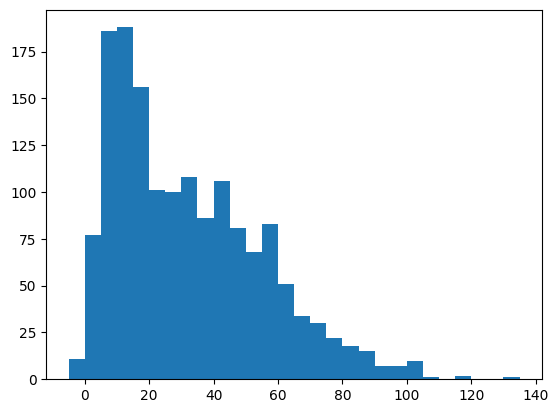

In [3]:
bin_width = 5
bins = np.arange(min(data["Weeks"]), max(data["Weeks"]) + bin_width, bin_width)

weeks_dist = plt.hist(data["Weeks"], bins=bins)

For now, FVC readings measured pre-CT scans are dropped, then readings are grouped by Weeks, at a 5-week interval.

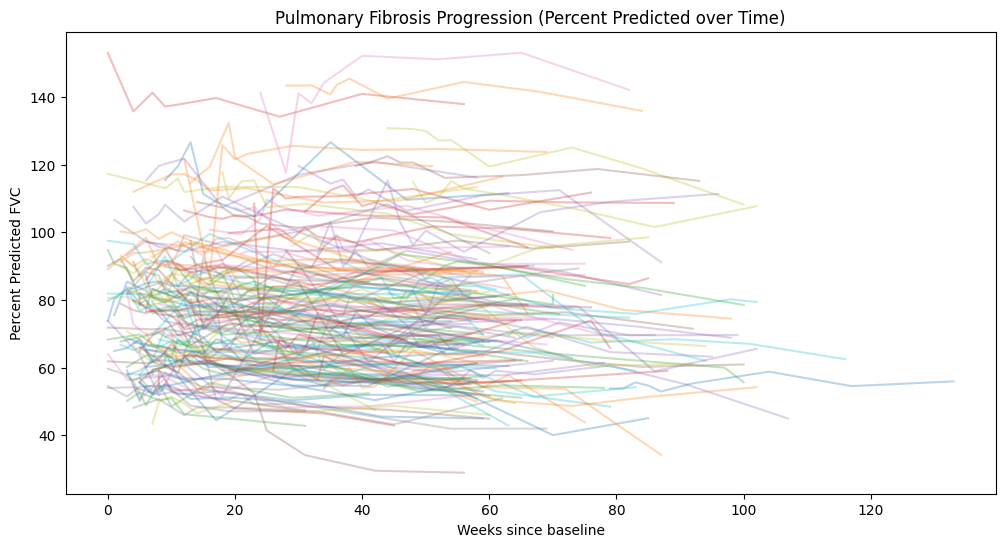

In [9]:
post_CT_data = data[data["Weeks"]>=0]
plt.figure(figsize=(12, 6))

for patient, pdata in post_CT_data.groupby("Patient"):
    plt.plot(pdata["Weeks"], pdata["Percent"], alpha=0.3)

plt.xlabel("Weeks since baseline")
plt.ylabel("Percent Predicted FVC")
plt.title("Pulmonary Fibrosis Progression (Percent Predicted over Time)")
plt.show()

Overall trend of decreasing percent values is observed. Now, effect of age is assessed, but there is a limitation: the readings are taken irregularly, so it is challenging to compute a metric that expresses change in FVC from week 30 to week 0. Instead, a percentage decline is computed then plotted.

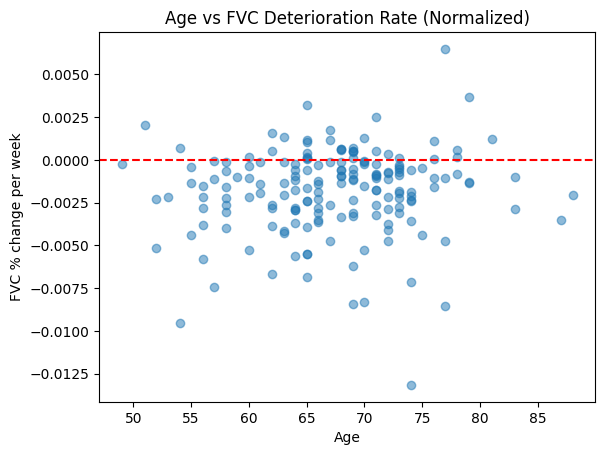

In [10]:
rates = []
ages = []

for patient, pdata in post_CT_data.groupby("Patient"):
    pdata = pdata.sort_values("Weeks")
    fvc_first = pdata["FVC"].iloc[0]
    fvc_last = pdata["FVC"].iloc[-1]
    t_first = pdata["Weeks"].iloc[0]
    t_last = pdata["Weeks"].iloc[-1]
    
    if t_last > t_first:  # avoid divide by zero
        decline_rate = (fvc_last - fvc_first) / (fvc_first * (t_last - t_first))
        rates.append(decline_rate)
        ages.append(pdata["Age"].iloc[0])

plt.scatter(ages, rates, alpha=0.5)
plt.xlabel("Age")
plt.ylabel("FVC % change per week")
plt.title("Age vs FVC Deterioration Rate (Normalized)")
plt.axhline(0, color="red", linestyle="--")
plt.show()

Not much correlation between age and relative FVC decline is shown in this plot.

Analysis of sex against fvc


In [ ]:
# Average FVC over Weeks grouped by Sex
plt.figure(figsize=(10,6))

# Lineplot with mean + standard deviation confidence bands
sns.lineplot(x="Weeks", y="FVC", hue="Sex", data=data,
             estimator="mean", ci="sd", marker="o")

plt.title("Average FVC over Weeks by Sex")
plt.xlabel("Weeks")
plt.ylabel("FVC (Forced Vital Capacity)")
plt.legend(title="Sex")
plt.grid(True)
plt.show()


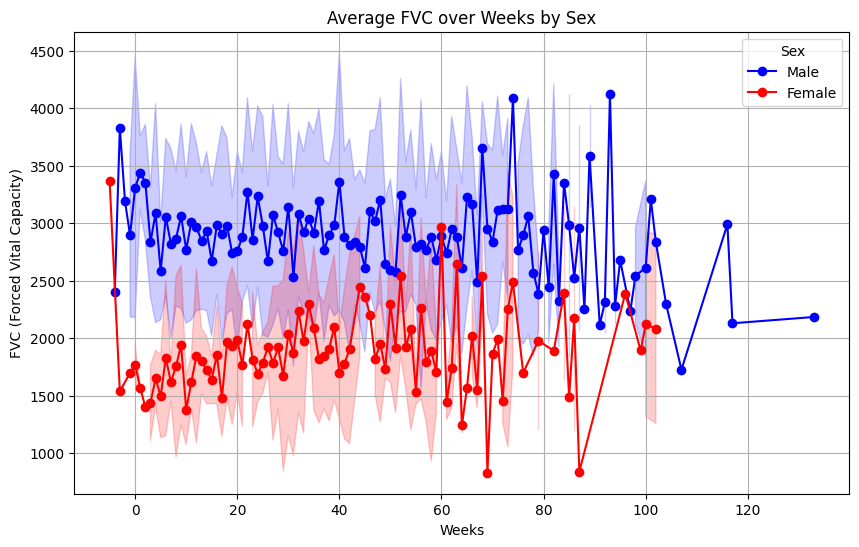

In [4]:
import matplotlib.pyplot as plt

# Group data by Weeks and Sex to compute mean and std
sex_weeks = data.groupby(["Weeks", "Sex"])["FVC"].agg(["mean", "std"]).reset_index()

plt.figure(figsize=(10,6))

# Plot Male
male = sex_weeks[sex_weeks["Sex"] == "Male"]
plt.plot(male["Weeks"], male["mean"], label="Male", color="blue", marker="o")
plt.fill_between(male["Weeks"], male["mean"] - male["std"], male["mean"] + male["std"],
                 alpha=0.2, color="blue")

# Plot Female
female = sex_weeks[sex_weeks["Sex"] == "Female"]
plt.plot(female["Weeks"], female["mean"], label="Female", color="red", marker="o")
plt.fill_between(female["Weeks"], female["mean"] - female["std"], female["mean"] + female["std"],
                 alpha=0.2, color="red")

# Labels and title
plt.title("Average FVC over Weeks by Sex")
plt.xlabel("Weeks")
plt.ylabel("FVC (Forced Vital Capacity)")
plt.legend(title="Sex")
plt.grid(True)
plt.show()


The blue line (Male) is consistently higher than the red line (Female) which matches expectations since on average, males have larger lung volumes than females due to physiological differences (height, chest size, etc.).

Males (blue band) show larger variability in FVC compared to females. This means some males decline much faster/slower than others, while female patients are more tightly clustered around the average, suggesting more heterogeneity in the disease course of male patients.

The rate of decline looks similar for both sexes

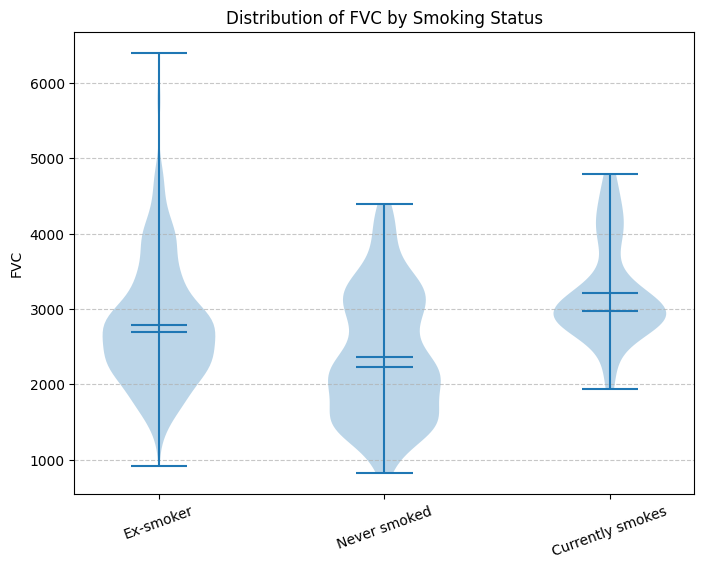

In [8]:

groups = [data.loc[data["SmokingStatus"] == status, "FVC"].dropna() 
          for status in data["SmokingStatus"].unique()]
labels = data["SmokingStatus"].unique()

plt.figure(figsize=(8,6))
plt.violinplot(groups, showmeans=True, showmedians=True)
plt.xticks(range(1, len(labels)+1), labels, rotation=20)
plt.title("Distribution of FVC by Smoking Status")
plt.ylabel("FVC")
plt.grid(True, axis="y", linestyle="--", alpha=0.7)
plt.show()



Patients who currently smoke generally exhibit higher FVC values than those who have never smoked, while ex-smokers show a wider distribution with more variability and some very low values. This suggests that smoking history influences lung function, but the relationship is not entirely linear. Current smokers not always showing the lowest FVC, possibly due to sample variation or confounding factors such as age or disease severity.

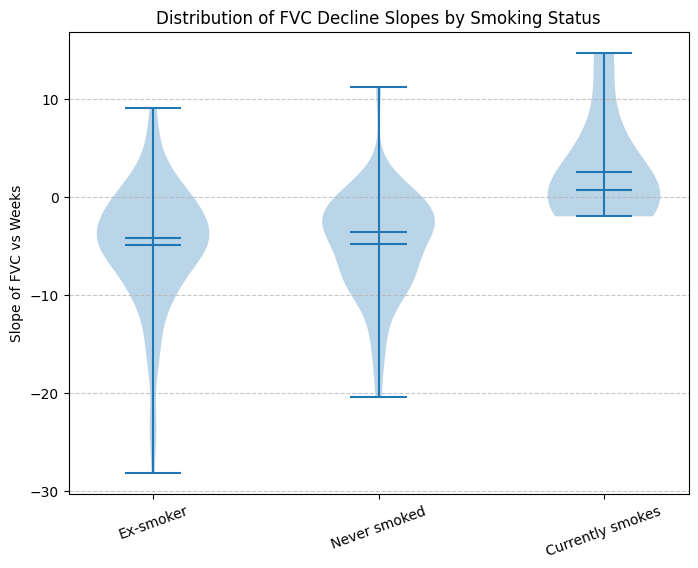

In [10]:

from sklearn.linear_model import LinearRegression

# Compute per-patient slopes
slopes = []
for patient, subdata in data.groupby("Patient"):
    X = subdata["Weeks"].values.reshape(-1,1)
    y = subdata["FVC"].values
    if len(X) > 1:  # need at least 2 points for regression
        model = LinearRegression().fit(X, y)
        slope = model.coef_[0]
        smoking = subdata["SmokingStatus"].iloc[0]
        slopes.append((smoking, slope))

# Organize slopes into groups
slopes_data = pd.DataFrame(slopes, columns=["SmokingStatus", "Slope"])
groups_slopes = [slopes_data.loc[slopes_data["SmokingStatus"] == status, "Slope"] 
                 for status in slopes_data["SmokingStatus"].unique()]
labels_slopes = slopes_data["SmokingStatus"].unique()

plt.figure(figsize=(8,6))
plt.violinplot(groups_slopes, showmeans=True, showmedians=True)
plt.xticks(range(1, len(labels_slopes)+1), labels_slopes, rotation=20)
plt.title("Distribution of FVC Decline Slopes by Smoking Status")
plt.ylabel("Slope of FVC vs Weeks")
plt.grid(True, axis="y", linestyle="--", alpha=0.7)
plt.show()


More negative slopes indicate faster declines in lung function. Both ex-smokers and never-smokers display predominantly negative slopes, suggesting ongoing decline in FVC over time, with ex-smokers showing wider variability and some steeper declines. Interestingly, current smokers show slopes closer to zero, with less negative median values, implying a slower average rate of decline in this dataset. This counterintuitive result may reflect selection bias (e.g., only healthier smokers being captured) or limitations in sample size rather than a true protective effect of smoking.